In [427]:
from collections.abc import Callable
from scipy.stats import rv_discrete, norm
import numpy as np
import matplotlib.pyplot as plt
import market_behavior_utils as mbu
from datetime import datetime as DT
import pandas as pd

In [29]:
initial_price = 4
u = 2
r = 0.25
K = 5

In [41]:
def pay_off_euro_call(price,strike):
    return max(0,price-strike)

def pay_off_euro_put(price,strike):
    return max(0,strike-price)

def pay_off_forward(price,strike):
    return price - strike

In [46]:
def no_arbitrage_probs(up_factor:float,down_factor:float,rate:float) -> tuple[float]:
    if down_factor > 0 and down_factor < 1 + rate and 1 + rate < up_factor:
        p_0 = (1+rate-down_factor)/(up_factor - down_factor)
    else:
        print("No-Abitrage Conditions Are Not Meet")
        p_0 = - 1
    return (p_0, 1 - p_0)

In [ ]:
def fair_option_price_one_period(initial_price:float,up_factor:float,down_factor:float,rate:float,strike:float,pay_off_funct:Callable[[float,float],float]) -> tuple[float]:
    
    p_0, q_0 = no_arbitrage_probs(up_factor,down_factor,rate)

    s_1_u = up_factor * initial_price
    s_1_d = down_factor * initial_price
    
    v_1_u = pay_off_funct(s_1_u,strike)
    v_1_d = pay_off_funct(s_1_d,strike)
    v_0 = (1/(1+rate))*(p_0*v_1_u + q_0*v_1_d)
    delta_0 = (v_1_u - v_1_d)/(s_1_u - s_1_d)

    return (v_0, delta_0)

In [49]:
fair_option_price_one_period(initial_price,u,1/u,r,K,pay_off_euro_call)

(1.2000000000000002, 0.5)

In [75]:
def fair_option_price_N_period(periods:int,initial_price:float,up_factor:float,down_factor:float,rate:float,strike:float,pay_off_funct:Callable[[float,float],float]) -> float:
    p_0, q_0 = no_arbitrage_probs(up_factor,down_factor,rate)

    nth_prices = {}

    for i in range(periods+1):
        current_price = initial_price*(up_factor**i)*(down_factor**(periods-i))
        nth_prices[current_price] = pay_off_funct(current_price,strike)

    for j in range(periods-1,-1,-1):
        nm1th_prices = {}
        for i in range(j+1):
            current_price = initial_price*(up_factor**i)*(down_factor**(j-i))
            nm1th_prices[current_price] = (1/(rate+1))*(nth_prices[current_price*up_factor]*p_0 + nth_prices[current_price*down_factor]*q_0)
        nth_prices = nm1th_prices
    
    return nth_prices[initial_price]
    
    


In [81]:
fair_option_price_N_period(2,initial_price,u,1/u,r,K,pay_off_euro_put)

0.96

In [275]:
# Symmetric walk
symmetric_walk = rv_discrete(a=-1,b=1,values=([-1,1],[0.5,0.5]))

def brownian_rvs(dt:float,M:int,steps:int) -> np.ndarray:
    return norm.rvs(loc=0,scale=np.sqrt(dt),size=(M,steps))


In [ ]:
# Symmetric walk with N steps, M iterations

def symmetric_random_walk(N:int,M:int)->tuple[np.ndarray,np.ndarray]:
    
    steps = symmetric_walk.rvs(size=(M,N))
    loc = np.cumsum(steps,axis=1)
    loc = np.hstack([np.zeros((M,1)),loc])
    step_count = np.arange(0,N+1)
    
    return (step_count,loc)


In [233]:
N = 400
M = 5000
x, ys_rw = symmetric_random_walk(N,M)

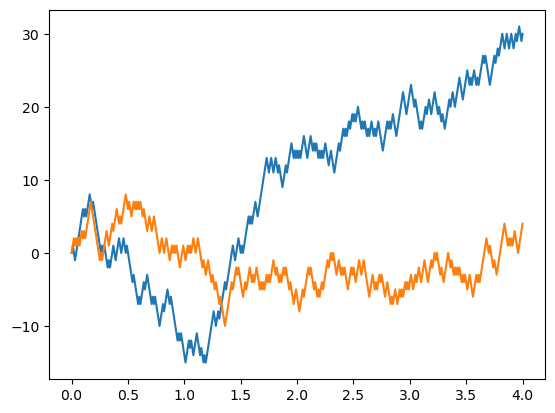

In [236]:
plt.plot(x/100,ys_rw[0],x/100,ys_rw[2])

In [ ]:
def path_increment(l:int,k:int,paths:np.ndarray) -> tuple[float,float]:
    increments = paths[:,l] - paths[:,k]
    mean = np.mean(increments) 
    var = np.var(increments,mean=mean)
    return (mean,var)

In [238]:
k = 1
ls = np.arange(k+1,N,1)
increment_kls = [path_increment(l,k,ys_rw) for l in ls]

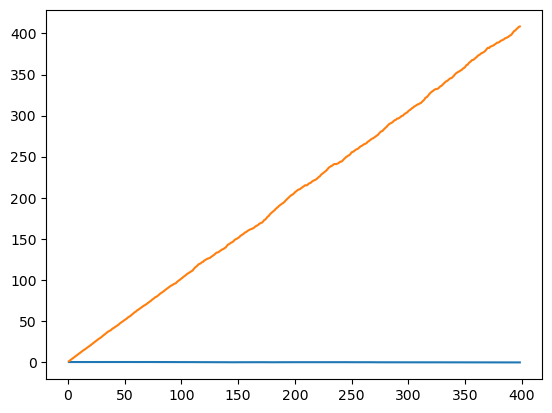

In [239]:
plt.plot(ls-k,increment_kls)

In [240]:
def quadratic_variation(k:int,path:np.ndarray) -> float:
    increments = np.diff(path,n=1)
    squared_increments = np.square(increments)
    
    return np.sum(squared_increments[:k])

In [241]:
quadratic_variation(2,ys_rw[0])

np.float64(2.0)

In [ ]:
def approximate_brownian_motion(n:int,t:int,M:int) -> tuple[np.ndarray,np.ndarray]:
    N = n*t
    step_count, loc = symmetric_random_walk(N,M)
    return step_count/n, (1/np.sqrt(n))*loc

In [251]:
x_b,ys_b = approximate_brownian_motion(100,4,M)

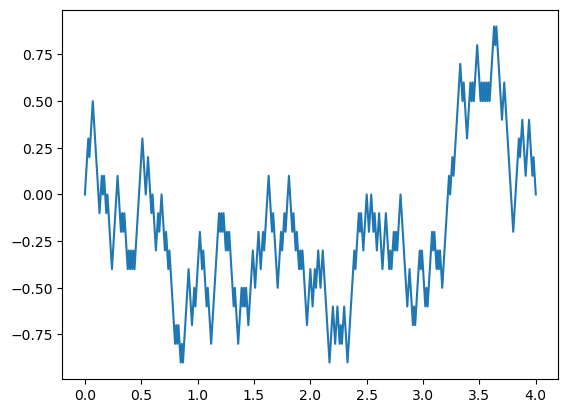

In [252]:
plt.plot(x_b,ys_b[0])

In [276]:
def continuous_brownian_motion(T:float,steps:int,realizations:int) -> tuple[np.ndarray,np.ndarray]:
    t_space = np.linspace(0,T,num=steps)
    dt = t_space[1] - t_space[0]
    increments = brownian_rvs(dt,realizations,steps-1)
    paths = np.cumsum(increments,axis=1)
    paths = np.hstack([np.zeros((realizations,1)),paths])
    return t_space, paths

In [298]:
T = 10
steps = 10000
x_bc, ys_bc = continuous_brownian_motion(T,steps,M)

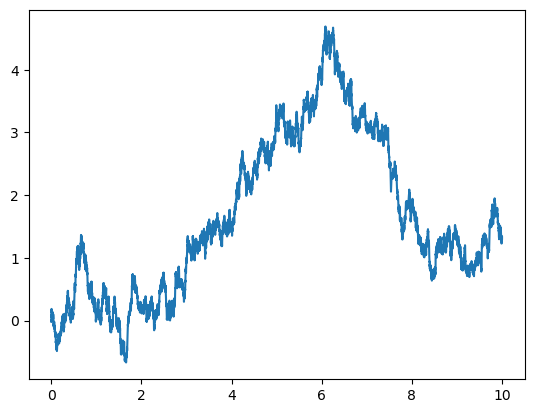

In [299]:
plt.plot(x_bc,ys_bc[1])

In [300]:
quadratic_variation(steps,ys_bc[0])

np.float64(9.855183048765316)

In [307]:
def gbm(start_price:float,mean:float,volatility:float,T:float,steps:int,realizations:int) -> tuple[np.ndarray,np.ndarray]:
    t_space, paths = continuous_brownian_motion(T,steps,realizations)
    vol_brownian = volatility * paths
    drift = (mean - 0.5*(volatility**2)) * t_space[np.newaxis,:]

    return t_space, start_price * np.exp(vol_brownian + drift)

In [311]:
x_gbm, ys_gbm = gbm(100,0.08,0.2,10,400,1000)

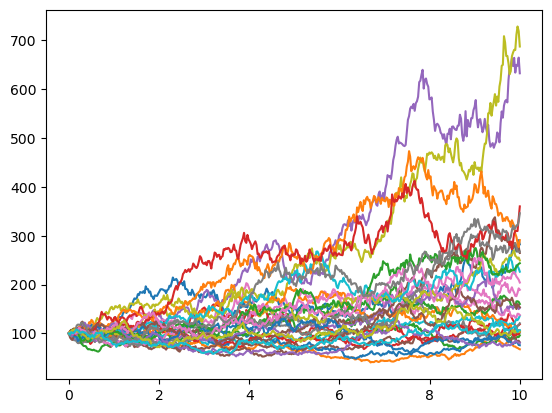

In [316]:
for ys in ys_gbm[10:40]:
    plt.plot(x_gbm,ys)

In [321]:
start,end = DT(2023,1,1),DT(2025,1,1)
spy_data = mbu.grab_ticker(start,end,["SPY"])

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_quant_foundations\market_behavior_utils.py:120: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True)
[*********************100%***********************]  1 of 1 completed


In [483]:
close_price = spy_data["CLOSE_SPY"].dropna()
close_log = spy_data["LOG_SPY"].dropna()
years_past = (spy_data.index[-1] - spy_data.index[0]).days / 365

In [484]:
initial_price = close_price.iloc[0]
empirical_vol = np.sqrt(252) * close_log.std()
empirical_mean = (1/years_past)*np.log(close_price.iloc[-1]/close_price.iloc[0]) + 0.5*empirical_vol**2

In [485]:
print(empirical_mean, empirical_vol)

0.2383293114406582 0.1282119638319579


In [572]:
sim_count=1000
time_steps, predicted_spys = gbm(initial_price,empirical_mean,empirical_vol,years_past,len(close_price),sim_count)

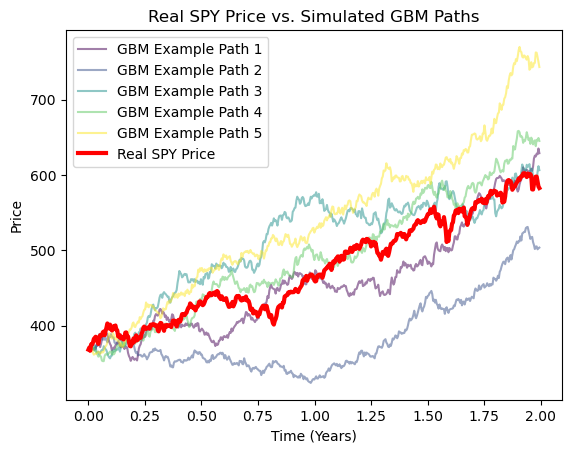

In [573]:
display_count = min(5,sim_count)
colors = plt.cm.viridis(np.linspace(0, 1, display_count))

for i in range(display_count):
    plt.plot(time_steps, predicted_spys[i], label=f'GBM Example Path {i+1}',alpha=0.5,color=colors[i])
plt.plot(time_steps, close_price, label='Real SPY Price',linewidth=3,color='red')
plt.title('Real SPY Price vs. Simulated GBM Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [574]:
simulated_df = pd.DataFrame(data=predicted_spys.T,index=close_price.index,columns=[(f"close_run_{i}").upper() for i in range(1,sim_count+1)])
log_return_cols = []
for i in range(1,sim_count+1):
    log_returns = np.log(simulated_df[(f"close_run_{i}").upper()].pct_change() + 1)
    log_return_cols.append(log_returns)

cols_to_dict = [s.to_dict() for s in log_return_cols]
log_return_df = pd.DataFrame(cols_to_dict).T
log_return_df.rename(lambda x: (f"log_returns_run_{x+1}").upper() ,axis="columns",inplace=True)
simulated_df = pd.concat([simulated_df,log_return_df],axis=1)

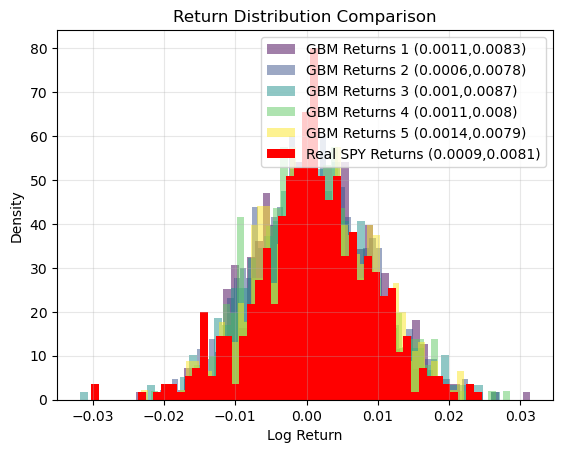

In [575]:
decimal_places = 4
for i in range(display_count):
    current_frame = simulated_df[(f"log_returns_run_{i+1}").upper()]
    mean, std = round(current_frame.mean(),decimal_places), round(current_frame.std(),decimal_places)
    plt.hist(simulated_df[(f"log_returns_run_{i+1}").upper()], bins=50, alpha=0.5, label=f'GBM Returns {i+1} ({mean},{std})',density=True,color=colors[i])
mean, std = round(close_log.mean(),decimal_places), round(close_log.std(),decimal_places)
plt.hist(close_log, bins=50, label=f'Real SPY Returns ({mean},{std})',density=True,color='red')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Return Distribution Comparison')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [576]:
simulated_moments = mbu.moments_df(simulated_df)
real_moments = mbu.moments_df(spy_data)

In [610]:
price_moments_mean = simulated_moments.loc["mean"].iloc[:sim_count]
price_moments_std = simulated_moments.loc["std"].iloc[:sim_count]
price_moments_skew = simulated_moments.loc["skew"].iloc[:sim_count]
price_moments_kurt = simulated_moments.loc["kurt"].iloc[:sim_count]

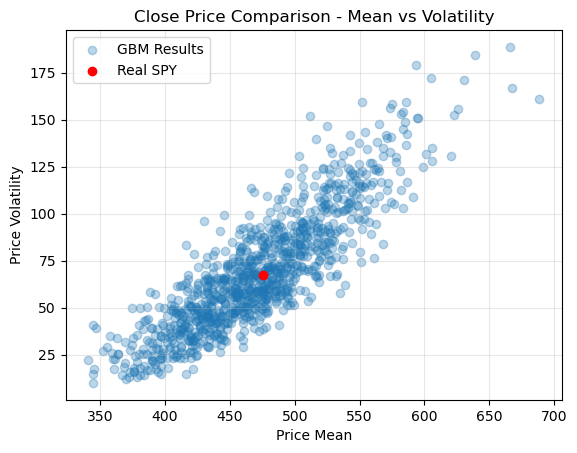

In [617]:
plt.scatter(price_moments_mean,price_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["mean"]],[real_moments["CLOSE_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Price Mean')
plt.ylabel('Price Volatility')
plt.title('Close Price Comparison - Mean vs Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

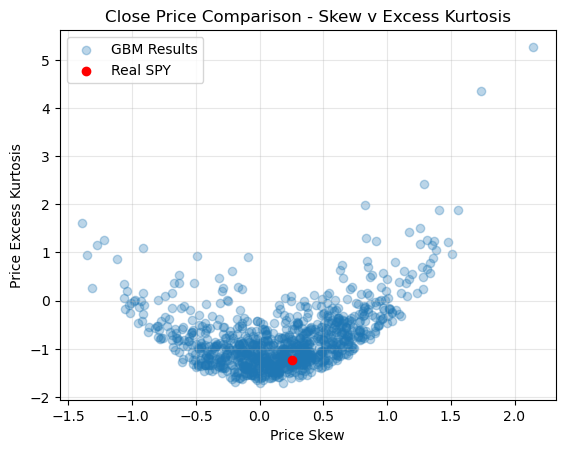

In [624]:
plt.scatter(price_moments_skew,price_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["skew"]],[real_moments["CLOSE_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Price Skew')
plt.ylabel('Price Excess Kurtosis')
plt.title('Close Price Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

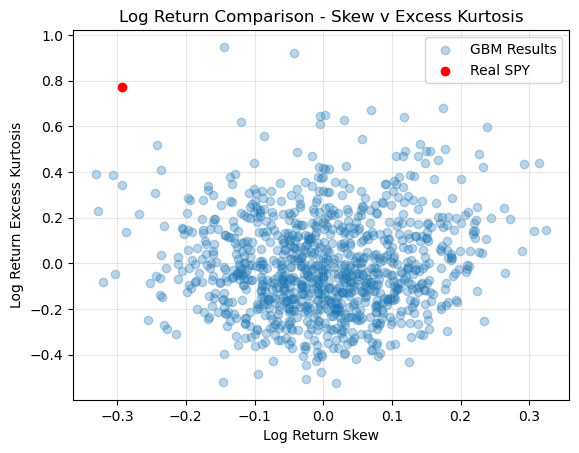

In [623]:
log_moments_mean = simulated_moments.loc["mean"].iloc[sim_count:]
log_moments_std = simulated_moments.loc["std"].iloc[sim_count:]
log_moments_skew = simulated_moments.loc["skew"].iloc[sim_count:]
log_moments_kurt = simulated_moments.loc["kurt"].iloc[sim_count:]

plt.scatter(log_moments_skew,log_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["skew"]],[real_moments["LOG_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Log Return Skew')
plt.ylabel('Log Return Excess Kurtosis')
plt.title('Log Return Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

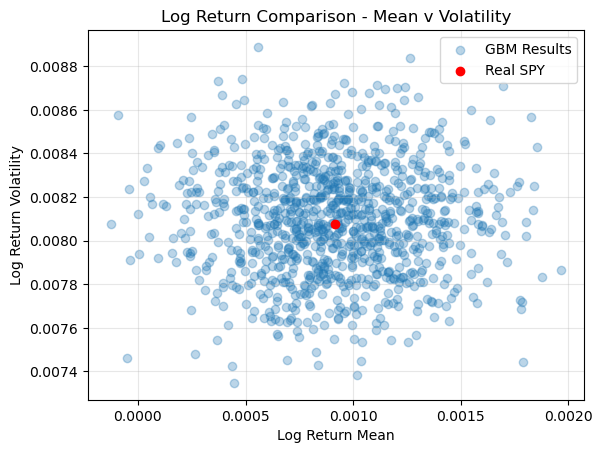

In [ ]:
plt.scatter(log_moments_mean,log_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["mean"]],[real_moments["LOG_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Log Return Mean')
plt.ylabel('Log Return Volatility')
plt.title('Log Return Comparison - Mean v Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

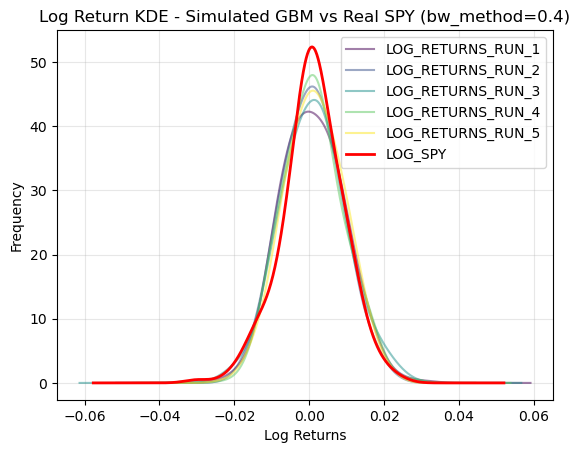

In [668]:
all_data = pd.concat([simulated_df,spy_data],axis=1)
method = 0.4
ax = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot.kde(alpha=0.5,color=colors,bw_method=method)
all_data["LOG_SPY"].plot.kde(ax=ax,linewidth=2,alpha=1.0,color='red',label="LOG_SPY",bw_method=method)
plt.title(f"Log Return KDE - Simulated GBM vs Real SPY (bw_method={method})")
plt.ylabel('Frequency')
plt.xlabel('Log Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [674]:
window = "30D"
all_log_data = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(sim_count)]+["LOG_SPY"]]
all_log_rolling = all_log_data.rolling(window=window)

all_rollings = []
for i in range(sim_count+1):
    if i == sim_count:
        key = "LOG_SPY"
    else:
        key = (f"log_returns_run_{i+1}").upper() 
    
    single_rollings = all_log_rolling[key].std()
    all_rollings.append(single_rollings)

cols_to_dict = [s.to_dict() for s in all_rollings]
rolling_vol = pd.DataFrame(cols_to_dict).T
rolling_vol.rename(lambda x: (f"log_returns_run_{x+1}").upper() if x != sim_count else "LOG_SPY" ,axis="columns",inplace=True)

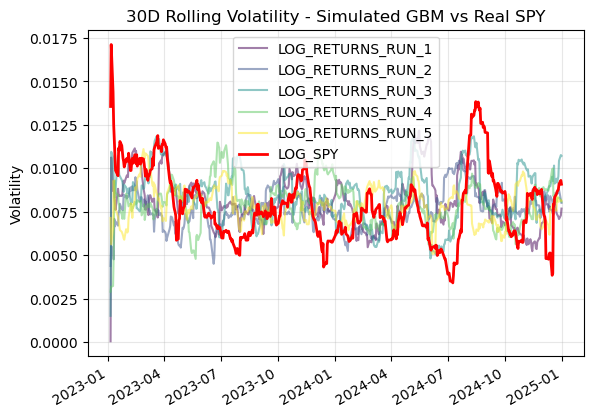

In [675]:
ax = rolling_vol[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot(alpha=0.5,color=colors)
rolling_vol["LOG_SPY"].plot(ax=ax,linewidth=2,alpha=1.0,color='red',label='LOG_SPY')
plt.title(f'{window} Rolling Volatility - Simulated GBM vs Real SPY')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()